In [1]:
# Imports
from datasets import load_dataset
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import random
import pandas as pd
import os, json
from transformers import pipeline
import torch
from torchmetrics.text.rouge import ROUGEScore
from torch.utils.data import Subset

/home/ss14412/.conda/envs/news-unmasked-gpu/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the dataset

In [3]:
dataset = load_dataset("generative-newsai/news-unmasked")

Found cached dataset parquet (/home/ss14412/.cache/huggingface/datasets/generative-newsai___parquet/generative-newsai--news-unmasked-afc734a91f0700d7/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 2/2 [00:00<00:00, 455.68it/s]


In [4]:
train_set = dataset["train"]
test_set = dataset["test"]

# Visualizing the data

In [5]:
train_set.__len__(), test_set.__len__()

(48988, 12247)

In [6]:
train_set.features, test_set.features

({'image': Image(decode=True, id=None),
  'section': Value(dtype='string', id=None),
  'headline': Value(dtype='string', id=None),
  'image_id': Value(dtype='string', id=None)},
 {'image': Image(decode=True, id=None),
  'section': Value(dtype='string', id=None),
  'headline': Value(dtype='string', id=None),
  'image_id': Value(dtype='string', id=None)})

In [7]:
train_set[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x295>,
 'section': 'Education',
 'headline': "Role for Teachers Is Seen in Solving Schools ' Crises",
 'image_id': '000055fd-f997-57a0-b586-49eaf0d930fc'}

In [8]:
test_set[random.choice(range(test_set.__len__()))]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x330>,
 'section': 'Automobiles',
 'headline': 'Altima : Sailing Into the Mainstream',
 'image_id': 'b382a0a8-e9e3-58fb-8da8-777a8b8531c7'}

In [9]:
# how many test headlines have [MASK] in them?
mask_token = "[MASK]"
test_with_mask = [x for x in test_set["headline"] if mask_token in x]
print(f"{len(test_with_mask)} out of {len(test_set)} test headlines have [MASK] in them")

5701 out of 12247 test headlines have [MASK] in them


In [10]:
# get tests without [MASK] in them
test_without_mask = [x for x in test_set["headline"] if mask_token not in x]
print(f"{len(test_without_mask)} out of {len(test_set)} test headlines do not have [MASK] in them")

6546 out of 12247 test headlines do not have [MASK] in them


Headlines with no mask in test set

In [11]:
test_without_mask[random.choice(range(len(test_without_mask)))]

"' The Good Lord Bird ' Review : The Necessity of John Brown"

In [12]:
sections = np.unique(test_set["section"])
print("Unique sections in the test dataset: ", len(sections))

Unique sections in the test dataset:  24


Observations: We have image, section and a masked headline. We need to predict the appropriate word for the masked headline.

In [13]:
# how many train headlines have [MASK] in them?
train_with_mask = [x for x in train_set["headline"] if mask_token in x]
print(f"{len(train_with_mask)} out of {len(train_set)} train headlines have [MASK] in them")

0 out of 48988 train headlines have [MASK] in them


In [14]:
sections = np.unique(train_set["section"])
print("Unique sections in the train dataset: ", len(sections))

Unique sections in the train dataset:  24


Observations: Not all the test entries have [MASK] token in them and there are 24 unique sections in the dataset.

## Plot section count

In [15]:
%%script false --no-raise-error

# Plot np unique with counts
z_train = np.unique(train_set["section"], return_counts=True)
z_test = np.unique(test_set["section"], return_counts=True)

# np unique returns sorted unique elements
assert np.array_equal(z_train[0], z_test[0])

# plot grouped bar chart
fig, ax = plt.subplots()
x = np.arange(len(z_train[0]))
width = 0.35
rects1 = ax.bar(x - width / 2, z_train[1], width, label="Train")
rects2 = ax.bar(x + width / 2, z_test[1]*(train_set.__len__()/test_set.__len__()), width, 
                label="Scaled Up Test")
ax.set_ylabel("Count")
ax.set_title("Count by Section")
ax.set_xticks(x)
ax.set_xticklabels(z_train[0])
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=90)
plt.show()

Observations: We have 24 unique sections with Well, Education, Global Business, Your Money, Economy and Automobiles having lowest occurence. Train dataset and test dataset follow similar pattern for section distribution

## Plot headline length by section

In [16]:
%%script false --no-raise-error

# Group headline_length_per_section by section
from itertools import groupby

def groupby_section(dataset):
    ln_per_section = list(zip(dataset["section"], [len(headline) for headline in dataset["headline"]]))
    ln_per_section = sorted(ln_per_section, key=lambda x: x[0])
    ln_per_section = [(key, list(group)) for key, group in groupby(ln_per_section, lambda x: x[0])]
    ln_per_section = [(key, [x[1] for x in group]) for key, group in ln_per_section]
    ln_stats_per_section = [(key, np.mean(group), np.std(group)) for key, group in ln_per_section]
    return ln_stats_per_section

train_ln_stats_per_section = groupby_section(train_set)
test_ln_stats_per_section = groupby_section(test_set)

In [17]:
%%script false --no-raise-error

# Plot train_ln_stats_per_section and test_ln_stats_per_section as grouped bar chart with error bars
fig, ax = plt.subplots()
x = np.arange(len(train_ln_stats_per_section))
width = 0.35
rects1 = ax.bar(x - width / 2, [x[1] for x in train_ln_stats_per_section], width, 
                yerr=[x[2] for x in train_ln_stats_per_section], label="Train")
rects2 = ax.bar(x + width / 2, [x[1] for x in test_ln_stats_per_section], width, 
                yerr=[x[2] for x in test_ln_stats_per_section], label="Test")
ax.set_ylabel("Headline Length")
ax.set_title("Headline Length by Section")
ax.set_xticks(x)
ax.set_xticklabels([x[0] for x in train_ln_stats_per_section])
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.xticks(rotation=90)
plt.show()


Observations: No outliers in headline length. We can see that the length of the headline is similar across all sections and lies between ~30 to ~80 characters.

## Sample images

Uncomment to visualize

In [18]:
%%script false --no-raise-error

imgs = []
for i, section in enumerate(tqdm(sections)):
    indices = random.choices(np.where(np.asarray(train_set["section"]) == section)[0], k=5)
    imgs.append(train_set[indices]["image"])

In [19]:
%%script false --no-raise-error

# Plot images for each section
fig, axs = plt.subplots(6, 4, figsize=(20, 20))
for i, ax in enumerate(axs.flat):
    ax.imshow(imgs[i][random.randint(0, 4)])
    ax.set_title(sections[i])
    ax.axis("off")
plt.subplots_adjust(wspace=0)
plt.show()

In [20]:
%%script false --no-raise-error

[img.size for img in train_set[random.sample(range(train_set.__len__()), 10)]["image"]]

Observations: Visualized Images have nytimes labeel showing what year it was printed, and sizes vary across images

# Deberta-Base-Uncased

Based on the sample notebook provided --> https://huggingface.co/datasets/generative-newsai/news-unmasked/blob/main/.extras/helper_notebook.ipynb

In [21]:
%%script false --no-raise-error

model_name = "mlcorelib/deberta-base-uncased"
unmasker = pipeline('fill-mask', model=model_name)

## Check first 5 rows of the Test dataset

In [22]:
%%script false --no-raise-error

# Check first 5 rows of the test dataset
sample_data = test_set[:5]
for k, v in sample_data.items():
    print("-"*50)
    print(k)
    print(*v, sep="\n")

## Unmask the sentences

In [23]:
%%script false --no-raise-error

all_masked_words = []
test_subset = Subset(test_set, range(100))
for each_dict in tqdm(test_subset):
    sentence = each_dict['headline']  # Get the sentence from the dictionary
    image_id = each_dict['image_id']  # Get the image_id from the dictionary
    if "[MASK]" in sentence: # See if it has a [MASK] in headline
        result = unmasker(sentence)  # Unmask the sentence

        # Make a list of indices where [MASK] is present in the sentence
        # If there are more than one [MASK] in the sentence, then add them as separate entries in the result list
        indices = [i for i, x in enumerate(sentence.split()) if x == "[MASK]"]
        if len(indices) > 1:
            masked_word_idx_list = []
            for i, each_result in enumerate(result):
                # Get the top scoring word
                top_word = each_result[0]['token_str']
                all_masked_words.append([image_id, indices[i], top_word])
        else:
            all_masked_words.append([image_id, indices[0], result[0]['token_str']])

final_masked_words = [l[0] for l in all_masked_words]

## Print first 5 rows of the masked words list

In [24]:
%%script false --no-raise-error

print(final_masked_words[:5])

## Save the results as a dataframe and print first 5 rows of the dataframe

In [25]:
%%script false --no-raise-error

# Save the results in a dataframe with column name id,token_index,token
df = pd.DataFrame(all_masked_words, columns=['id', 'token_index', 'token'])
df.head()

## Save the dataframe as a csv file

In [26]:
%%script false --no-raise-error

df.to_csv('sample_result.csv', index=False)

# Vision Language Models

## Idea: Caption the image
Ask LLM caption + mask sentence. Predict masks

In [27]:
# divide train_set in train and validation
train_train_set, train_val_set = torch.utils.data.random_split(train_set, 
                                                               [int(0.8 * len(train_set)),
                                                                len(train_set) - int(0.8 * len(train_set))])

In [28]:
len(train_train_set), len(train_val_set), len(train_set)

(39190, 9798, 48988)

### Image Captioning using hf pipelines

#### VIT-GPT2-COCO

In [34]:
device_id = 0 if torch.cuda.is_available() else -1

In [35]:
%%script false --no-raise-error

from transformers import pipeline
from torchmetrics.text.rouge import ROUGEScore

captioner = pipeline("image-to-text",model="ydshieh/vit-gpt2-coco-en", device=device_id)
captioner("https://huggingface.co/datasets/Narsil/image_dummy/raw/main/parrots.png")
## [{'generated_text': 'two birds are standing next to each other '}]

In [36]:
%%script false --no-raise-error

# Try captioner on one of the images in the validation set
rouge = ROUGEScore(use_stemmer=True)
sample = train_val_set[random.randint(0, len(train_val_set))]

caption = captioner(sample["image"], max_new_tokens=25)
rouge_score = rouge(caption[0]['generated_text'], sample["headline"])
plt.imshow(sample["image"])
print("generated_text: " + caption[0]['generated_text'], 
      "section: " + sample["section"],  
      "headline: " + sample["headline"], 
      "rouge1_fmeasure: " + str(rouge_score['rouge1_fmeasure']),
      "rouge2_fmeasure: " + str(rouge_score['rouge2_fmeasure']),
      "rougeL_fmeasure: " + str(rouge_score['rougeL_fmeasure']),
      "rougeLsum_fmeasure: " + str(rouge_score['rougeLsum_fmeasure']),
      sep="\n")

In [37]:
%%script false --no-raise-error

# rouge1_fmeasure across validation subset
rouge1_fmeasure = []
train_val_subset = Subset(train_val_set, range(100))
for data in tqdm(train_val_subset):
    caption = captioner(data["image"], max_new_tokens=25)
    rouge_score = rouge(caption[0]['generated_text'], data["headline"])
    rouge1_fmeasure.append(rouge_score['rouge1_fmeasure'])

In [38]:
%%script false --no-raise-error

np.mean(rouge1_fmeasure), np.std(rouge1_fmeasure)

#### BLIP image captioning large

In [39]:
captioner = pipeline("image-to-text",model="Salesforce/blip-image-captioning-large", device=device_id)
captioner("https://huggingface.co/datasets/Narsil/image_dummy/raw/main/parrots.png")
## VIT-GPT2 output: ## [{'generated_text': 'two birds are standing next to each other '}]
## BLIP output: [{'generated_text': 'there are two parrots that are standing next to each other'}]
## Observations: BLIP output seems more detailed

/home/ss14412/.conda/envs/news-unmasked-gpu/lib/python3.11/site-packages/transformers/generation/utils.py:1313: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'there are two parrots that are standing next to each other'}]

generated_text: there is a woman that is holding a microphone in her hand
section: Television
headline: What 's on TV Tuesday : ' Amy Schumer Growing ' and ' The Village '
rouge1_fmeasure: tensor(0.)
rouge2_fmeasure: tensor(0.)
rougeL_fmeasure: tensor(0.)
rougeLsum_fmeasure: tensor(0.)


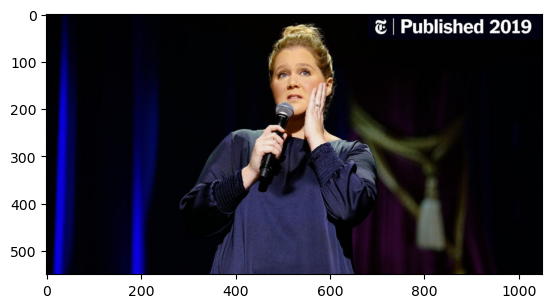

In [40]:
# Try captioner on one of the images in the validation set
rouge = ROUGEScore(use_stemmer=True)
sample = train_val_set[random.randint(0, len(train_val_set))]

caption = captioner(sample["image"], max_new_tokens=25)
rouge_score = rouge(caption[0]['generated_text'], sample["headline"])
plt.imshow(sample["image"])
print("generated_text: " + caption[0]['generated_text'], 
      "section: " + sample["section"],  
      "headline: " + sample["headline"], 
      "rouge1_fmeasure: " + str(rouge_score['rouge1_fmeasure']),
      "rouge2_fmeasure: " + str(rouge_score['rouge2_fmeasure']),
      "rougeL_fmeasure: " + str(rouge_score['rougeL_fmeasure']),
      "rougeLsum_fmeasure: " + str(rouge_score['rougeLsum_fmeasure']),
      sep="\n")

In [41]:
%%script false --no-raise-error

# rouge1_fmeasure across validation subset
rouge1_fmeasure = []
train_val_subset = Subset(train_val_set, range(100))
for data in tqdm(train_val_subset):
    caption = captioner(data["image"], max_new_tokens=25)
    rouge_score = rouge(caption[0]['generated_text'], data["headline"])
    rouge1_fmeasure.append(rouge_score['rouge1_fmeasure'])

In [42]:
%%script false --no-raise-error

np.mean(rouge1_fmeasure), np.std(rouge1_fmeasure)

# VIT-GPT2 scores: (0.06309018, 0.07374029)
# BLIP scores: (0.06341785, 0.069144554)

Observations:

Inference takes longer than VIT-GPT2 (4:47 as compared to 1:09 for inital 100 samples). Eye balling the results, BLIP image captioning large seems to be more specific to the image. VIT-GPT2 seems to be more generic. rouge score is slightly better for BLIP image captioning large for the first 100 samples. Std dev is also lower for BLIP image captioning large.

Conclusions:

Can try both models and see which gives better results for masked word prediction.

### Fill-Mask Pipeline

In [43]:
from transformers import pipeline

unmasker = pipeline("fill-mask", model="distilroberta-base", device=device_id)
unmasker("Paris is the <mask> of France.")

# [{'score': 0.7, 'sequence': 'Paris is the capital of France.'},
# {'score': 0.2, 'sequence': 'Paris is the birthplace of France.'},
# {'score': 0.1, 'sequence': 'Paris is the heart of France.'}]

[{'score': 0.6790170073509216,
  'token': 812,
  'token_str': ' capital',
  'sequence': 'Paris is the capital of France.'},
 {'score': 0.05178032070398331,
  'token': 32357,
  'token_str': ' birthplace',
  'sequence': 'Paris is the birthplace of France.'},
 {'score': 0.03825294226408005,
  'token': 1144,
  'token_str': ' heart',
  'sequence': 'Paris is the heart of France.'},
 {'score': 0.024349091574549675,
  'token': 29778,
  'token_str': ' envy',
  'sequence': 'Paris is the envy of France.'},
 {'score': 0.022851329296827316,
  'token': 1867,
  'token_str': ' Capital',
  'sequence': 'Paris is the Capital of France.'}]

In [44]:
sample = train_val_set[random.randint(0, len(train_val_set))]

# replace random word with <mask>
masked_sample = sample["headline"].split()
rand_index = random.randint(0, len(masked_sample)-1)
print(f"rand index: {rand_index}, len of headline: {len(masked_sample)}")

masked_sample[rand_index] = "<mask>"
masked_sample = " ".join(masked_sample)
sample["headline"], masked_sample

rand index: 7, len of headline: 8


('60 Lives , 30 Kidneys , All Linked', '60 Lives , 30 Kidneys , All <mask>')

In [45]:
unmasked = unmasker(masked_sample)

# compute rouge score with original headline
rouge = ROUGEScore(use_stemmer=True)
print("original headline: " + sample["headline"], "section: " + sample["section"], sep="\n")
for i in range(len(unmasked)):
    rouge_score = rouge(unmasked[i]['sequence'], sample["headline"])
    print("generated_text: " + unmasked[i]['sequence'],  
          "rouge1_fmeasure: " + str(rouge_score['rouge1_fmeasure']),
          "rouge2_fmeasure: " + str(rouge_score['rouge2_fmeasure']),
          "rougeL_fmeasure: " + str(rouge_score['rougeL_fmeasure']),
          "rougeLsum_fmeasure: " + str(rouge_score['rougeLsum_fmeasure']),
          sep="\n")

original headline: 60 Lives , 30 Kidneys , All Linked
section: Health
generated_text: 60 Lives, 30 Kidneys, All About
rouge1_fmeasure: tensor(0.8333)
rouge2_fmeasure: tensor(0.8000)
rougeL_fmeasure: tensor(0.8333)
rougeLsum_fmeasure: tensor(0.8333)
generated_text: 60 Lives, 30 Kidneys, All Children
rouge1_fmeasure: tensor(0.8333)
rouge2_fmeasure: tensor(0.8000)
rougeL_fmeasure: tensor(0.8333)
rougeLsum_fmeasure: tensor(0.8333)
generated_text: 60 Lives, 30 Kidneys, All Things
rouge1_fmeasure: tensor(0.8333)
rouge2_fmeasure: tensor(0.8000)
rougeL_fmeasure: tensor(0.8333)
rougeLsum_fmeasure: tensor(0.8333)
generated_text: 60 Lives, 30 Kidneys, AllGov
rouge1_fmeasure: tensor(0.7273)
rouge2_fmeasure: tensor(0.6667)
rougeL_fmeasure: tensor(0.7273)
rougeLsum_fmeasure: tensor(0.7273)
generated_text: 60 Lives, 30 Kidneys, All Stars
rouge1_fmeasure: tensor(0.8333)
rouge2_fmeasure: tensor(0.8000)
rougeL_fmeasure: tensor(0.8333)
rougeLsum_fmeasure: tensor(0.8333)


### Fill mask pipeline with caption as prompt

In [48]:
def randomMask(input, mask_token="<mask>"):
    masked_input = input.split()
    rand_index = random.randint(0, len(masked_input)-1)
    masked_input[rand_index] = mask_token
    masked_input = " ".join(masked_input)
    return masked_input

original headline: Michael Friedman , a Man of Many Voices and a Gift for Prophecy
section: Theater
caption: arafed image of a man sitting at a piano and singing
masked_sample: Michael Friedman , a Man of Many Voices <mask> a Gift for Prophecy
unmasked: Michael Friedman, a Man of Many Voices: a Gift for Prophecy
prompted_unmasked: Michael Friedman, a Man of Many Voices: a Gift for Prophecy


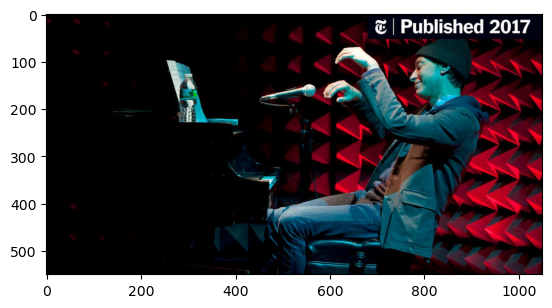

In [49]:
sample = train_val_set[random.randint(0, len(train_val_set))]
masked_sample = randomMask(sample["headline"])
sample["headline"], masked_sample

PADDING = "[ pad ]"
caption = captioner(sample["image"], max_new_tokens=25)
unmasked = unmasker(masked_sample)
prompted_unmasked = unmasker(caption[0]['generated_text'] + PADDING + masked_sample)

plt.imshow(sample["image"])
print("original headline: " + sample["headline"], "section: " + sample["section"], sep="\n")
print("caption: " + caption[0]['generated_text'], "masked_sample: " + masked_sample, 
      "unmasked: " + unmasked[0]['sequence'], 
      "prompted_unmasked: " + prompted_unmasked[0]['sequence'].split(PADDING)[1],
        sep="\n")

In [50]:
%%script false --no-raise-error

# What percentage improves with prompting?

train_val_subset = Subset(train_val_set, range(100))
rouge1_fmeasure_prompted = []
rouge1_fmeasure_unprompted = []
for data in tqdm(train_val_subset):
    caption = captioner(data["image"], max_new_tokens=25)
    
    masked_sample = randomMask(data["headline"])
    
    unmasked = unmasker(masked_sample)
    prompted_unmasked = unmasker(caption[0]['generated_text'] + PADDING + masked_sample)
    rouge1_fmeasure_prompted.append(rouge(prompted_unmasked[0]['sequence'].split(PADDING)[1], 
                                          data["headline"])['rouge1_fmeasure'])
    rouge1_fmeasure_unprompted.append(rouge(unmasked[0]['sequence'],
                                            data["headline"])['rouge1_fmeasure'])

In [51]:
%%script false --no-raise-error

rouge1_fmeasure_prompted = np.array(rouge1_fmeasure_prompted)
rouge1_fmeasure_unprompted = np.array(rouge1_fmeasure_unprompted)
print(np.mean(rouge1_fmeasure_prompted), np.std(rouge1_fmeasure_prompted), 
      np.mean(rouge1_fmeasure_unprompted), np.std(rouge1_fmeasure_unprompted))
print(np.mean(rouge1_fmeasure_prompted > rouge1_fmeasure_unprompted))

#### Running on test set

In [52]:
%%script false --no-raise-error

mask_token = "[MASK]"
test_indices_with_mask = [i for i, x in enumerate(test_set["headline"]) if mask_token in x]

In [53]:
%%script false --no-raise-error

from torch.utils.data import Subset

all_masked_words = []
test_subset = Subset(test_set, test_indices_with_mask)
for each_dict in tqdm(test_subset):
    image = each_dict['image']  # Get the image from the dictionary
    sentence = each_dict['headline']  # Get the sentence from the dictionary
    image_id = each_dict['image_id']  # Get the image_id from the dictionary
    if "[MASK]" in sentence: # See if it has a [MASK] in headline
        sentence = sentence.replace("[MASK]", "<mask>")
        caption = captioner(image, max_new_tokens=25)
        result = unmasker(caption[0]['generated_text'] + PADDING + sentence)
        
        # result = prompted_unmasked[0]['sequence'].split(PADDING)[1]

        # Make a list of indices where [MASK] is present in the sentence
        # If there are more than one [MASK] in the sentence, then add them as separate entries in the result list
        indices = [i for i, x in enumerate(sentence.split()) if x == "<mask>"]
        if len(indices) > 1:
            masked_word_idx_list = []
            for i, each_result in enumerate(result):
                # Get the top scoring word
                top_word = each_result[0]['token_str']
                all_masked_words.append([image_id, indices[i], top_word])
        else:
            all_masked_words.append([image_id, indices[0], result[0]['token_str']])

final_masked_words = [l[0] for l in all_masked_words]

In [54]:
%%script false --no-raise-error

len(final_masked_words), np.unique(final_masked_words).shape

In [55]:
%%script false --no-raise-error

df = pd.DataFrame(all_masked_words, columns=['id', 'token_index', 'token'])
df.head()

In [56]:
%%script false --no-raise-error

df.to_csv('sample_result.csv', index=False)

### Fill Mask with caption + section as prompt

<mask> Backs Foreign Investment in Retailing
original headline: India Backs Foreign Investment in Retailing
section: Global Business
caption: people shopping in a grocery store with a large amount of produce
masked_sample: <mask> Backs Foreign Investment in Retailing
unmasked: China Backs Foreign Investment in Retailing
prompted_unmasked:  Bloomberg Backs Foreign Investment in Retailing
section_prompted_unmasked: Company Backs Foreign Investment in Retailing


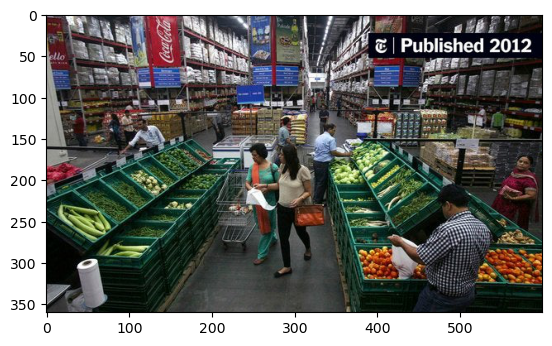

In [57]:
sample = train_val_set[random.randint(0, len(train_val_set))]
masked_sample = randomMask(sample["headline"])
sample["headline"], masked_sample

PADDING = "[ pad ]"
caption = captioner(sample["image"], max_new_tokens=25)
unmasked = unmasker(masked_sample)
prompted_unmasked = unmasker(caption[0]['generated_text'] + PADDING + masked_sample)
section_prompted_unmasked = unmasker(sample["section"] + PADDING + 
                                     caption[0]['generated_text'] + PADDING + masked_sample)

plt.imshow(sample["image"])
print("original headline: " + sample["headline"], "section: " + sample["section"], sep="\n")
print("caption: " + caption[0]['generated_text'], "masked_sample: " + masked_sample, 
      "unmasked: " + unmasked[0]['sequence'], 
      "prompted_unmasked: " + prompted_unmasked[0]['sequence'].split(PADDING)[1],
      "section_prompted_unmasked: " + section_prompted_unmasked[0]['sequence'].split(PADDING)[2],
        sep="\n")

In [69]:
%%script false --no-raise-error
# What percentage improves with adding section as a prompt as well?

train_val_subset = Subset(train_val_set, range(100))
rouge1_fmeasure_prompted = []
rouge1_fmeasure_unprompted = []
rouge1_fmeasure_section_prompted = []
for data in tqdm(train_val_subset):
    caption = captioner(data["image"], max_new_tokens=25)
    
    masked_sample = randomMask(data["headline"])
    
    unmasked = unmasker(masked_sample)
    prompted_unmasked = unmasker(caption[0]['generated_text'] + PADDING + masked_sample)
    section_prompted_unmasked = unmasker(data["section"] + PADDING +
                                            caption[0]['generated_text'] + PADDING + masked_sample)
    rouge1_fmeasure_prompted.append(rouge(prompted_unmasked[0]['sequence'].split(PADDING)[1], 
                                          data["headline"])['rouge1_fmeasure'])
    rouge1_fmeasure_unprompted.append(rouge(unmasked[0]['sequence'],
                                            data["headline"])['rouge1_fmeasure'])
    rouge1_fmeasure_section_prompted.append(rouge(section_prompted_unmasked[0]['sequence'].split(PADDING)[2],
                                            data["headline"])['rouge1_fmeasure'])

  0%|          | 0/100 [00:00<?, ?it/s]/home/ss14412/.conda/envs/news-unmasked-gpu/lib/python3.11/site-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 100/100 [00:28<00:00,  3.57it/s]


In [70]:
%%script false --no-raise-error
rouge1_fmeasure_prompted = np.array(rouge1_fmeasure_prompted)
rouge1_fmeasure_unprompted = np.array(rouge1_fmeasure_unprompted)
rouge1_fmeasure_section_prompted = np.array(rouge1_fmeasure_section_prompted)

print("prompted mean: ", np.mean(rouge1_fmeasure_prompted), "\n",
      "prompted std: ", np.std(rouge1_fmeasure_prompted), "\n",
      "unprompted mean: ", np.mean(rouge1_fmeasure_unprompted), "\n",
      "unprompted std: ", np.std(rouge1_fmeasure_unprompted), "\n",
      "section_prompted mean: ", np.mean(rouge1_fmeasure_section_prompted), "\n",
      "section_prompted std: ", np.std(rouge1_fmeasure_section_prompted))
print("prompted > unprompted: ", np.mean(rouge1_fmeasure_prompted > rouge1_fmeasure_unprompted) - 
      np.mean(rouge1_fmeasure_prompted < rouge1_fmeasure_unprompted), "\n",
      "section_prompted > unprompted: ", np.mean(rouge1_fmeasure_section_prompted > rouge1_fmeasure_unprompted) - 
      np.mean(rouge1_fmeasure_section_prompted < rouge1_fmeasure_unprompted), "\n",
      "prompted > section_prompted: ", np.mean(rouge1_fmeasure_prompted > rouge1_fmeasure_section_prompted) - 
      np.mean(rouge1_fmeasure_prompted < rouge1_fmeasure_section_prompted))

prompted mean:  0.8917552 
 prompted std:  0.07098623 
 unprompted mean:  0.8962248 
 unprompted std:  0.059734043 
 section_prompted mean:  0.8964005 
 section_prompted std:  0.074558005
prompted > unprompted:  -0.03 
 section_prompted > unprompted:  0.020000000000000004 
 prompted > section_prompted:  -0.049999999999999996


Observations:
- Adding section additionaly as the prompt sometimes improves the performance of the model.

Nothing conclusive can be said about the performance of the model with section as prompt. It seems to be working better for some sections and worse for others.

Maybe can add a description to section

tensor(0.1111) tensor(0.1111) tensor(0.1111) tensor(0.1111)
original headline: Meet Six Disrupters at the New Museum 's Triennial
section: Art & Design
caption: painting of a man and woman with a lion and a bird on a wall
masked_sample: Meet Six Disrupters <mask> the New Museum 's Triennial
unmasked: Meet Six Disrupters From the New Museum's Triennial
prompted_unmasked: Meet Six Disrupters From the New Museum's Triennial
section_prompted_unmasked: Meet Six Disrupters at the New Museum's Triennial
desc_prompted_unmasked: Meet Six Disrupters at the New Museum's Triennial


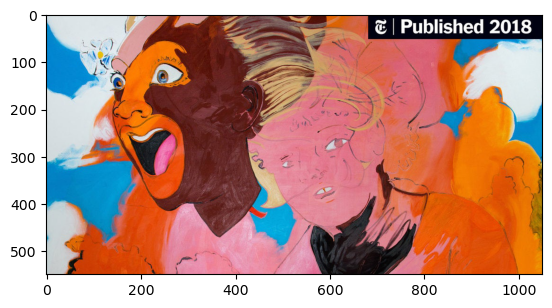

In [101]:
%%script false --no-raise-error
score1 = -1
score2 = -1
score3 = -1
score4 = -1
count = 1000

while (score1 <= 0 or score3 <= 0) and (score2 <= 0 or score4 <= 0) and count > 0:
      count -= 1
      sample = train_val_set[random.randint(0, len(train_val_set))]
      masked_sample = randomMask(sample["headline"])
      sample["headline"], masked_sample

      PADDING = "[ pad ]"
      caption = captioner(sample["image"], max_new_tokens=25)
      unmasked = unmasker(masked_sample)
      prompted_unmasked = unmasker(caption[0]['generated_text'] + PADDING + masked_sample)
      section_prompted_unmasked = unmasker(sample["section"] + PADDING + 
                                          caption[0]['generated_text'] + PADDING + masked_sample)
      desc_prompted_unmasked = unmasker("The context for the caption is {0}.".format(sample["section"]) + PADDING +
                                    caption[0]['generated_text'] + PADDING + masked_sample)
      score1 = rouge(desc_prompted_unmasked[0]['sequence'].split(PADDING)[2],
                     sample["headline"])['rouge1_fmeasure'] - rouge(unmasked[0]['sequence'],
                                                                    sample["headline"])['rouge1_fmeasure']
      score2 = rouge(section_prompted_unmasked[0]['sequence'].split(PADDING)[2],
                     sample["headline"])['rouge1_fmeasure'] - rouge(unmasked[0]['sequence'],
                                                                    sample["headline"])['rouge1_fmeasure']
      score3 = rouge(desc_prompted_unmasked[0]['sequence'].split(PADDING)[2],
                     sample["headline"])['rouge1_fmeasure'] - rouge(
                           prompted_unmasked[0]['sequence'].split(PADDING)[1],
                           sample["headline"])['rouge1_fmeasure']
      score4 = rouge(section_prompted_unmasked[0]['sequence'].split(PADDING)[2],
                        sample["headline"])['rouge1_fmeasure'] - rouge(
                              prompted_unmasked[0]['sequence'].split(PADDING)[1],
                              sample["headline"])['rouge1_fmeasure']

print(score1, score2, score3, score4)
plt.imshow(sample["image"])
print("original headline: " + sample["headline"], "section: " + sample["section"], sep="\n")
print("caption: " + caption[0]['generated_text'], "masked_sample: " + masked_sample, 
      "unmasked: " + unmasked[0]['sequence'], 
      "prompted_unmasked: " + prompted_unmasked[0]['sequence'].split(PADDING)[1],
      "section_prompted_unmasked: " + section_prompted_unmasked[0]['sequence'].split(PADDING)[2],
      "desc_prompted_unmasked: " + desc_prompted_unmasked[0]['sequence'].split(PADDING)[2],
      sep="\n")

In [80]:
%%script false --no-raise-error
# What percentage improves with adding section as a prompt as well?

train_val_subset = Subset(train_val_set, range(100))
rouge1_fmeasure_prompted = []
rouge1_fmeasure_unprompted = []
rouge1_fmeasure_section_prompted = []
rouge1_fmeasure_desc_prompted = []
for data in tqdm(train_val_subset):
    caption = captioner(data["image"], max_new_tokens=25)
    
    masked_sample = randomMask(data["headline"])
    
    unmasked = unmasker(masked_sample)
    prompted_unmasked = unmasker(caption[0]['generated_text'] + PADDING + masked_sample)
    section_prompted_unmasked = unmasker(data["section"] + PADDING +
                                            caption[0]['generated_text'] + PADDING + masked_sample)
    desc_prompted_unmasked = unmasker("The context for the caption is {0}.".format(data["section"]) + PADDING +
                                            caption[0]['generated_text'] + PADDING + masked_sample)
    rouge1_fmeasure_prompted.append(rouge(prompted_unmasked[0]['sequence'].split(PADDING)[1], 
                                          data["headline"])['rouge1_fmeasure'])
    rouge1_fmeasure_unprompted.append(rouge(unmasked[0]['sequence'],
                                            data["headline"])['rouge1_fmeasure'])
    rouge1_fmeasure_section_prompted.append(rouge(section_prompted_unmasked[0]['sequence'].split(PADDING)[2],
                                            data["headline"])['rouge1_fmeasure'])
    rouge1_fmeasure_desc_prompted.append(rouge(desc_prompted_unmasked[0]['sequence'].split(PADDING)[2],
                                            data["headline"])['rouge1_fmeasure'])

  0%|          | 0/100 [00:00<?, ?it/s]/home/ss14412/.conda/envs/news-unmasked-gpu/lib/python3.11/site-packages/transformers/pipelines/base.py:1070: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
100%|██████████| 100/100 [00:28<00:00,  3.55it/s]


In [81]:
%%script false --no-raise-error
rouge1_fmeasure_prompted = np.array(rouge1_fmeasure_prompted)
rouge1_fmeasure_unprompted = np.array(rouge1_fmeasure_unprompted)
rouge1_fmeasure_section_prompted = np.array(rouge1_fmeasure_section_prompted)
rouge1_fmeasure_desc_prompted = np.array(rouge1_fmeasure_desc_prompted)

print("prompted mean: ", np.mean(rouge1_fmeasure_prompted), "\n",
      "prompted std: ", np.std(rouge1_fmeasure_prompted), "\n",
      "unprompted mean: ", np.mean(rouge1_fmeasure_unprompted), "\n",
      "unprompted std: ", np.std(rouge1_fmeasure_unprompted), "\n",
      "section_prompted mean: ", np.mean(rouge1_fmeasure_section_prompted), "\n",
      "section_prompted std: ", np.std(rouge1_fmeasure_section_prompted), "\n",
      "desc_prompted mean: ", np.mean(rouge1_fmeasure_desc_prompted), "\n",
      "desc_prompted std: ", np.std(rouge1_fmeasure_desc_prompted))
print("prompted > unprompted: ", np.mean(rouge1_fmeasure_prompted > rouge1_fmeasure_unprompted) - 
      np.mean(rouge1_fmeasure_prompted < rouge1_fmeasure_unprompted), "\n",
      "section_prompted > unprompted: ", np.mean(rouge1_fmeasure_section_prompted > rouge1_fmeasure_unprompted) - 
      np.mean(rouge1_fmeasure_section_prompted < rouge1_fmeasure_unprompted), "\n",
      "prompted > section_prompted: ", np.mean(rouge1_fmeasure_prompted > rouge1_fmeasure_section_prompted) - 
      np.mean(rouge1_fmeasure_prompted < rouge1_fmeasure_section_prompted), "\n",
      "desc_prompted > unprompted: ", np.mean(rouge1_fmeasure_desc_prompted > rouge1_fmeasure_unprompted) -
      np.mean(rouge1_fmeasure_desc_prompted < rouge1_fmeasure_unprompted), "\n",
      "desc_prompted > prompted: ", np.mean(rouge1_fmeasure_desc_prompted > rouge1_fmeasure_prompted) -
      np.mean(rouge1_fmeasure_desc_prompted < rouge1_fmeasure_prompted), "\n",
      "desc_prompted > section_prompted: ", np.mean(rouge1_fmeasure_desc_prompted > rouge1_fmeasure_section_prompted) -
      np.mean(rouge1_fmeasure_desc_prompted < rouge1_fmeasure_section_prompted))

prompted mean:  0.9024768 
 prompted std:  0.07374704 
 unprompted mean:  0.90376276 
 unprompted std:  0.06865566 
 section_prompted mean:  0.902067 
 section_prompted std:  0.0746578 
 desc_prompted mean:  0.9029727 
 desc_prompted std:  0.075067535
prompted > unprompted:  -0.010000000000000002 
 section_prompted > unprompted:  -0.009999999999999998 
 prompted > section_prompted:  0.0 
 desc_prompted > unprompted:  -0.009999999999999998 
 desc_prompted > prompted:  0.0 
 desc_prompted > section_prompted:  0.0


Observations:
- Adding descriptive section as a prompt sometime shows improvements over unprompted and prompted.

Need to check what works better on what kind of random masking

Can we just take all of them and ensemble them somehow?

### Cosine similarity between section and caption as per authors